In [1]:
# This script is a demo for reconstructing linear events via High-resolution Linear Radon transform

import numpy as np
import matplotlib.pyplot as plt

def radon_op(din,param,oper):
    h=param['h']
    v=param['v']
    nt=param['nt']
    dt=param['dt']
    type=param['type']
    
    nh=len(h)
    nv=len(v)
    
    if oper == -1:
        m=np.zeros([nt,nv]);
       
    if oper == 1:
        d=np.zeros([nt,nh]);
    
    if oper == -1:
        d=din;
        
    if oper == 1:
        m=din;
        
    for itau in range(1,nt+1):
        for ih in range(1,nh+1):
            for iv in range(1,nv+1):
                
                if type==1:
                    t = (itau-1)*dt + h[ih-1]/v[iv-1];
                    it = np.floor(t/dt)+1;
                    it=np.int32(it);
                elif type==2:
                    t = (itau-1)*dt + h[ih-1]*h[ih-1]*v[iv-1]/hmax/hmax;   
                    it = np.floor(t/dt)+1;
                    it=np.int32(it);
                elif type==3:
                    t = np.sqrt (((itau-1)*dt)*((itau-1)*dt) + (h[ih-1]/v[iv-1])*(h[ih-1]/v[iv-1]) ) ;
                    it = np.floor(t/dt)+1;
                    it=np.int32(it);
                else:
                    t = np.sqrt (((itau-1)*dt)*((itau-1)*dt) + (h[ih-1]/v[iv-1])*(h[ih-1]/v[iv-1]) ) ;
                    it = np.floor(t/dt)+1;
                    it=np.int32(it);
                    
                if it <= nt and it-1>0:
                    if oper == -1:
                        m[itau-1,iv-1] = m[itau-1,iv-1] + d[it-1,ih-1];
                    if oper == 1:
                        d[it-1,ih-1]  = d[it-1,ih-1] + m[itau-1,iv-1];
    if oper == 1:
        return d;
    if oper == -1:
        return m;
    
def ricker(f,dt,tlength=None):
    # ricker: Ricker wavelet of central frequency f.
    #
    # INPUT:
    # f : central freq. in Hz (f <<1/(2dt) )
    # dt: sampling interval in sec
    # tlength : the duration of wavelet in sec
    #
    # OUTPUT: 
    # w:  the Ricker wavelet
    # tw: time axis
    #
    # Example
    #
    #   [w,tw] = ricker(10,0.004,0.2);
    #   pyplot.plot(tw,w);
    import numpy as np
    
    if tlength!=None:
        nw=np.floor(tlength/dt)+1;
    else:
        nw=2.2/f/dt;
        nw=2*np.floor(nw/2)+1;
    nc=np.floor(nw/2);
    nw=int(nw)
    w =np.zeros(nw);
    
    k=np.arange(1,nw+1,1);
    alpha = (nc-k+1)*f*dt*np.pi;
    beta=np.power(alpha,2);
    w = (1.-beta*2)*np.exp(-beta);
    tw = -(nc+1-k)*dt;
    return w,tw

In [2]:
dp=0.05;dh=0.1;

h=np.linspace(0,6,int(6/dh+1));

nh=len(h);
p=np.linspace(-0.6,0.60,int(1.21/dp)+1);
nnp=len(p);

dt=0.2;nt=501;
m=np.zeros([nt,nnp]);
d=np.zeros([nt,nh]);
w,tw=ricker(0.5,dt);

In [3]:
tau=[100,200,250];
p0=[0,0.1,0.1];

In [4]:
m[tau[0]-1,12]=1;
m[tau[1]-1,18]=0.4;
m[tau[2]-1,18]=0.5;
# t = np.convolve(m[:,1],w,'same');
import scipy.signal
w=np.expand_dims(w,1);
m=scipy.signal.convolve2d(m,w,'same');

par={'h':h,'v':1/(p+0.00000000001),'nt':nt,'dt':dt,'type':1}

#Forward operator
d=radon_op(m,par,1);
#Adjoint operator
ma = radon_op(d,par,-1);

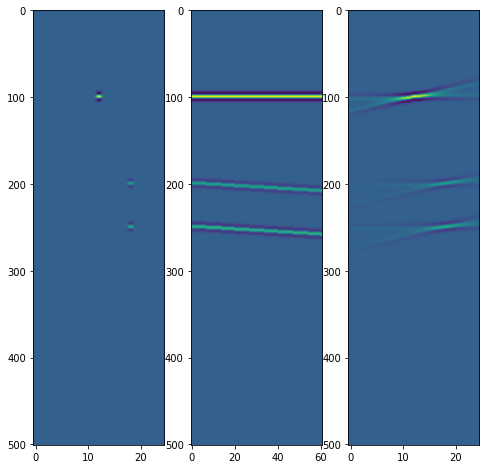

In [5]:
plt.figure(figsize=(8, 8));
plt.subplot(1,3,1)
plt.imshow(m,aspect='auto');
plt.subplot(1,3,2)
plt.imshow(d,aspect='auto');
plt.subplot(1,3,3)
plt.imshow(ma,aspect='auto');
plt.show()

In [6]:
def pcg(oper,par,d,m0,niter_in=10,niter_out=1,verb=0):
    # Precondioned CG for solving sparsity-promoting inverse problems
    # 
    # 
    # Reference: Hestenes, M. R., & Stiefel, E. (1952). Methods of conjugate gradients for solving. Journal of research of the National Bureau of Standards, 49(6), 409.
    #
    
    u=m0;
    P=np.ones(u.shape); #P is an diagonal weighting operator, so I used capital P
    kc=0;
    mis=[];
    m=u;
    for l in range(niter_out):
        di=oper(P*u,par,1);
        r=d-di;
        
        g=oper(r,par,-1);
        g=g*P;
        s=g;
        gammam=np.sum(g*np.conj(g));
        for k in range(niter_in):
            q=oper(P*s,par,1);
            den=np.sum(q*np.conj(q));
            alpha=gammam/(den+1.e-8);
            u=u+alpha*s;
            r=r-alpha*q;
            mis.append(np.sum(r*np.conj(r)));
            g=oper(r,par,-1);
            g=g*P;
            gamma=np.sum(g*np.conj(g));
            beta=gamma/(gammam+1.e-7);
            gammam=gamma;
            s=g+beta*s;
            if verb:
                print("Outer iteration=%d, Inner iteration = %d, Current misfit=%0.5g \n"%(l+1,k+1,mis[kc]));
            kc=kc+1;
        m=P*u;
        P=np.abs(m/np.max(m.flatten()))+0.001;
    mis=np.array(mis);
    return m,mis
    
    

In [7]:
## Least-squares inversion

N1 = 10;  # CG Iterations (Internal loop);
N2 = 1;   # Update of weights for the sparse solution: N1 = 1 LS;  N2 > 3 for High Res (Sparse) solution
[mi,misfit] = pcg(radon_op,par,d,np.zeros(ma.shape),niter_in=N1,niter_out=N2,verb=1);

Outer iteration=1, Inner iteration = 1, Current misfit=39.542 

Outer iteration=1, Inner iteration = 2, Current misfit=12.526 

Outer iteration=1, Inner iteration = 3, Current misfit=6.5335 

Outer iteration=1, Inner iteration = 4, Current misfit=4.7298 

Outer iteration=1, Inner iteration = 5, Current misfit=3.9488 

Outer iteration=1, Inner iteration = 6, Current misfit=3.4958 

Outer iteration=1, Inner iteration = 7, Current misfit=3.1513 

Outer iteration=1, Inner iteration = 8, Current misfit=2.8837 

Outer iteration=1, Inner iteration = 9, Current misfit=2.6656 

Outer iteration=1, Inner iteration = 10, Current misfit=2.4799 



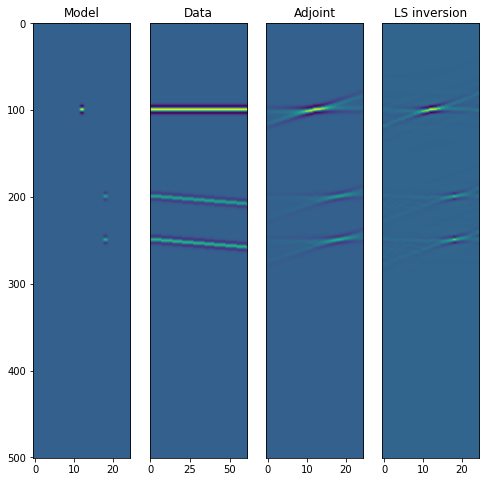

In [8]:
plt.figure(figsize=(8, 8));
plt.subplot(1,4,1)
plt.imshow(m,aspect='auto');plt.title('Model');
plt.subplot(1,4,2)
plt.imshow(d,aspect='auto');plt.title('Data');plt.gca().set_yticks([]);
plt.subplot(1,4,3)
plt.imshow(ma,aspect='auto');plt.title('Adjoint');plt.gca().set_yticks([]);
plt.subplot(1,4,4)
plt.imshow(mi,aspect='auto');plt.title('LS inversion');plt.gca().set_yticks([]);
plt.show()

Outer iteration=1, Inner iteration = 1, Current misfit=39.542 

Outer iteration=1, Inner iteration = 2, Current misfit=12.526 

Outer iteration=1, Inner iteration = 3, Current misfit=6.5335 

Outer iteration=1, Inner iteration = 4, Current misfit=4.7298 

Outer iteration=1, Inner iteration = 5, Current misfit=3.9488 

Outer iteration=1, Inner iteration = 6, Current misfit=3.4958 

Outer iteration=1, Inner iteration = 7, Current misfit=3.1513 

Outer iteration=1, Inner iteration = 8, Current misfit=2.8837 

Outer iteration=1, Inner iteration = 9, Current misfit=2.6656 

Outer iteration=1, Inner iteration = 10, Current misfit=2.4799 

Outer iteration=2, Inner iteration = 1, Current misfit=46.366 

Outer iteration=2, Inner iteration = 2, Current misfit=18.278 

Outer iteration=2, Inner iteration = 3, Current misfit=10.625 

Outer iteration=2, Inner iteration = 4, Current misfit=6.1685 

Outer iteration=2, Inner iteration = 5, Current misfit=4.489 

Outer iteration=2, Inner iteration = 6, 

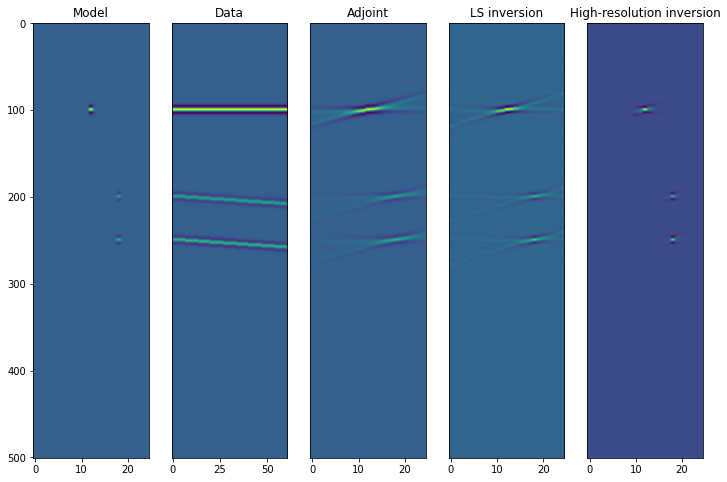

In [9]:
## High-resolution inversion

N1 = 10;  # CG Iterations (Internal loop);
N2 = 3;   # Update of weights for the sparse solution: N1 = 1 LS;  N2 > 3 for High Res (Sparse) solution
[mi_l1,misfit] = pcg(radon_op,par,d,np.zeros(ma.shape),niter_in=N1,niter_out=N2,verb=1);

plt.figure(figsize=(12, 8));
plt.subplot(1,5,1)
plt.imshow(m,aspect='auto');plt.title('Model');
plt.subplot(1,5,2)
plt.imshow(d,aspect='auto');plt.title('Data');plt.gca().set_yticks([]);
plt.subplot(1,5,3)
plt.imshow(ma,aspect='auto');plt.title('Adjoint');plt.gca().set_yticks([]);
plt.subplot(1,5,4)
plt.imshow(mi,aspect='auto');plt.title('LS inversion');plt.gca().set_yticks([]);
plt.subplot(1,5,5)
plt.imshow(mi_l1,aspect='auto');plt.title('High-resolution inversion');plt.gca().set_yticks([]);
plt.show()


In [10]:
# inversion and recovery
mask_inds=np.concatenate((np.linspace(1,31,31),np.linspace(45,50,16),np.linspace(55,61,7)),axis=0);
mask_inds=np.int32(mask_inds);
h_mis=h[mask_inds-1];
d_mis=d[:,mask_inds-1];

par={'h':h_mis,'v':1/(p+0.00000000001),'nt':nt,'dt':dt,'type':1};

ma=radon_op(d_mis,par,-1);
mi,mistmp=pcg(radon_op,par,d_mis,np.zeros(ma.shape),niter_in=10,niter_out=1,verb=1);
mi_l1,mistmp=pcg(radon_op,par,d_mis,np.zeros(ma.shape),niter_in=10,niter_out=3,verb=1);





Outer iteration=1, Inner iteration = 1, Current misfit=30.996 

Outer iteration=1, Inner iteration = 2, Current misfit=13.314 

Outer iteration=1, Inner iteration = 3, Current misfit=7.1984 

Outer iteration=1, Inner iteration = 4, Current misfit=5.0184 

Outer iteration=1, Inner iteration = 5, Current misfit=3.9987 

Outer iteration=1, Inner iteration = 6, Current misfit=3.3689 

Outer iteration=1, Inner iteration = 7, Current misfit=2.9387 

Outer iteration=1, Inner iteration = 8, Current misfit=2.5883 

Outer iteration=1, Inner iteration = 9, Current misfit=2.2455 

Outer iteration=1, Inner iteration = 10, Current misfit=2.0161 

Outer iteration=1, Inner iteration = 1, Current misfit=30.996 

Outer iteration=1, Inner iteration = 2, Current misfit=13.314 

Outer iteration=1, Inner iteration = 3, Current misfit=7.1984 

Outer iteration=1, Inner iteration = 4, Current misfit=5.0184 

Outer iteration=1, Inner iteration = 5, Current misfit=3.9987 

Outer iteration=1, Inner iteration = 6,

In [11]:
par['h']=h;
da=radon_op(ma,par,1);
di=radon_op(mi,par,1);
di_l1=radon_op(mi_l1,par,1);

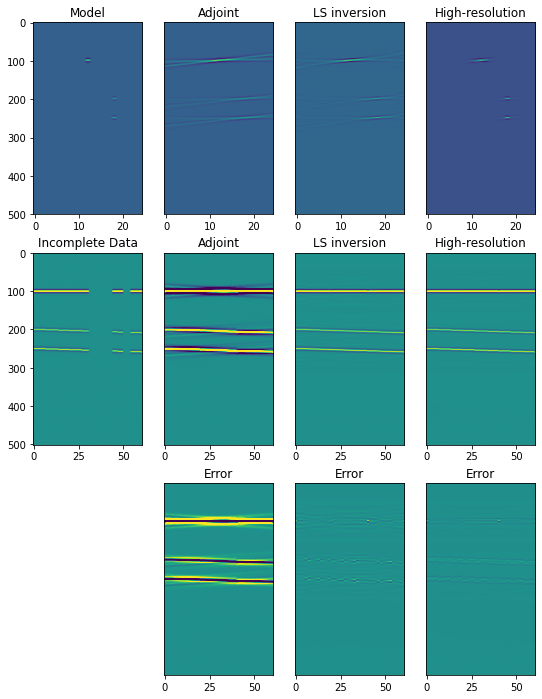

In [12]:
## Compare results

plt.figure(figsize=(9, 12));
plt.subplot(3,4,1)
plt.imshow(m,aspect='auto');plt.title('Model');
plt.subplot(3,4,5)

#pad zero for displaying
d_padzero=d;
d_mask=np.zeros(d.shape);d_mask[:,mask_inds-1]=1;
d_padzero=d*d_mask;
plt.imshow(d_padzero,aspect='auto',clim=(-0.5, 0.5));plt.title('Incomplete Data');


plt.subplot(3,4,2)
plt.imshow(ma,aspect='auto');plt.title('Adjoint');plt.gca().set_yticks([]);
plt.subplot(3,4,3)
plt.imshow(mi,aspect='auto');plt.title('LS inversion');plt.gca().set_yticks([]);
plt.subplot(3,4,4)
plt.imshow(mi_l1,aspect='auto');plt.title('High-resolution');plt.gca().set_yticks([]);

plt.subplot(3,4,6)
plt.imshow(da,aspect='auto',clim=(-50, 50));plt.title('Adjoint');plt.gca().set_yticks([]);
plt.subplot(3,4,7)
plt.imshow(di,aspect='auto',clim=(-0.5, 0.5));plt.title('LS inversion');plt.gca().set_yticks([]);
plt.subplot(3,4,8)
plt.imshow(di_l1,aspect='auto',clim=(-0.5, 0.5));plt.title('High-resolution');plt.gca().set_yticks([]);


plt.subplot(3,4,10)
plt.imshow(d-da,aspect='auto',clim=(-50, 50));plt.title('Error');plt.gca().set_yticks([]);
plt.subplot(3,4,11)
plt.imshow(d-di,aspect='auto',clim=(-0.2, 0.2));plt.title('Error');plt.gca().set_yticks([]);
plt.subplot(3,4,12)
plt.imshow(d-di_l1,aspect='auto',clim=(-0.2, 0.2));plt.title('Error');plt.gca().set_yticks([]);

